In [16]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'

#### Functions

In [17]:
def read_manning(site):
    """Read Alistair's baseline flags for a given site

    Args:
        site (str): Site code (e.g., MHD)

    Returns:
        pandas.DataFrame: DataFrame with baseline flags (binary)
    """
    
    site_translator = {"MHD": "MH"}

    # Filtering so only including data relevant to the given site
    files = (data_path / "manning_baselines").glob(f"{site_translator[site]}*.txt")

    dfs = []

    # Looping through each of the files for the given site
    for file in files:

        # Read the data, skipping metadata, putting into pandas dataframe
        data = pd.read_csv(file, skiprows=6, delim_whitespace=True)

        # Setting the index of the dataframe to be the extracted datetime and naming it time
        data.index = pd.to_datetime(data['YY'].astype(str) + "-" + \
                                    data['MM'].astype(str) + "-" + \
                                    data['DD'].astype(str) + " " + \
                                    data['HH'].astype(str) + ":00:00")

        data.index.name = "time"
        
        # Adding the 'Ct' column to the previously created empty list
        dfs.append(data[["Ct"]])
    
    # Creating a dataframe from the list containing all the 'Ct' values
    df = pd.concat(dfs)

    df.sort_index(inplace=True)
    
    # Replace all values in Ct column less than 10 or greater than 20 with 0
    # not baseline values
    df.loc[(df['Ct'] < 10) | (df['Ct'] >= 20), 'Ct'] = 0

    # Replace all values between 10 and 19 with 1
    # baseline values
    df.loc[(df['Ct'] >= 10) & (df['Ct'] < 20), 'Ct'] = 1

    # Rename Ct column to "baseline"
    df.rename(columns={'Ct': 'baseline'}, inplace=True)

    return df

In [18]:
def balance_baselines(ds, minority_ratio): 
    """
    Balances the dataset by randomly undersampling non-baseline data points.

    Parameters:
    ds (xarray.Dataset): The dataset to be balanced.
    minority_ratio (float): The desired ratio of baseline (minority class) data points in the final dataset. 
                            For example, 0.4 means 40% of data points will be baseline.

    Returns:
    xarray.Dataset: The balanced dataset where the ratio of baseline to non-baseline data points is as specified by the `minority_ratio` argument.

    Raises:
    ValueError: If the counts of baseline and non-baseline values are not in the expected ratio (within a tolerance of 1%).

    """

    # counting number of baseline&non-baseline data points
    baseline_count = ds['baseline'].where(ds['baseline']==1).count()
    non_baseline_count = ds['baseline'].where(ds['baseline']==0).count()

    # calculating the minority class count (expected to be baseline)
    minority_count = int(min(baseline_count, non_baseline_count))

    # calculating the majority class count based on majority_ratio and minority_count
    majority_ratio = 1 - minority_ratio
    majority_count = int(minority_count * (majority_ratio/minority_ratio))

    # randomly undersampling non-baseline based on majority_count
    np.random.seed(42)
    undersampled_non_baseline = ds.where(ds['baseline'] == 0, drop=True)
    undersampled_non_baseline = undersampled_non_baseline.isel(time=np.random.choice(undersampled_non_baseline.dims['time'], majority_count, replace=False))

    # combining the the undersampled non-baseline with the baseline values
    balanced_ds = xr.merge([ds.where(ds['baseline'] == 1), undersampled_non_baseline])
    balanced_ds = balanced_ds.sortby('time')

    # checking balance
    new_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==1).count()
    new_non_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==0).count()

    # verifying that the ratio of baseline:non-baseline data points is as expected (within a tolerance of 1%)
    tolerance = 0.01
    upper_bound = (1+tolerance)*(majority_ratio/minority_ratio)
    lower_bound = (1-tolerance)*(majority_ratio/minority_ratio)

    if(lower_bound <= (new_non_baseline_count/new_baseline_count) <= upper_bound):
        return balanced_ds
    else:
        raise ValueError("The counts of baseline and non-baseline values are not in the expected ratio.")

#### Mace Head

In [19]:
site = "MHD"
df = read_manning(site)

ds_flags = df.to_xarray()
balanced_ds_flags = balance_baselines(ds_flags, 0.7)

In [20]:
# Lazy load the NCEP data
# U is the zonal wind component (positive is eastward)
# V is the meridional wind component (positive is northward)

# WIND - SINGULAR DATA POINT
#ds_u = xr.open_mfdataset((data_path/"ncep_singular").glob("*u*.nc")).sel(dict(site=site, level=10))
#ds_v = xr.open_mfdataset((data_path/"ncep_singular").glob("*v*.nc")).sel(dict(site=site, level=10))

# WIND - NINE POINT SYSTEM
ds_u = xr.open_mfdataset((data_path/"ncep_9points").glob("*u*.nc")).sel(dict(site=site, level=10))
ds_v = xr.open_mfdataset((data_path/"ncep_9points").glob("*v*.nc")).sel(dict(site=site, level=10))

# SURFACE PRESSURE
ds_pres = xr.open_mfdataset((data_path/"surface_pressure"/"extracted_data").glob("*.nc")).sel(dict(site=site))

In [21]:
# Grab some AGAGE data 
# 134a
ds_mf = xr.open_dataset(data_path / f"agage-nc/data-gcms-nc/AGAGE-GCMS-Medusa_{site}_hfc-134a.nc")

In [22]:
# Create an xarray dataset with the u, v, mole fraction and baseline flags
# ORIGINAL DATASET
ds_uvf = xr.combine_by_coords([ds_u.reindex_like(ds_mf, method="nearest"),
                    ds_v.reindex_like(ds_mf, method="nearest"),
                    ds_pres.reindex_like(ds_mf, method="nearest"),
                    ds_flags.baseline.reindex_like(ds_mf, method="nearest"),
                    ds_mf.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# BALANCED DATASET
ds_uvf_balanced = xr.combine_by_coords([ds_u.reindex_like(ds_mf, method="nearest"),
                    ds_v.reindex_like(ds_mf, method="nearest"),
                    ds_pres.reindex_like(ds_mf, method="nearest"),
                    balanced_ds_flags.baseline.reindex_like(ds_mf, method="nearest"),
                    ds_mf.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# removing associated uwnd/vwnd/mf values associated the removed baseline values (removed for balancing)
# masking values where baseline is NaN
ds_uvf_balanced = ds_uvf_balanced.where(~np.isnan(ds_uvf_balanced['baseline']), drop=True)

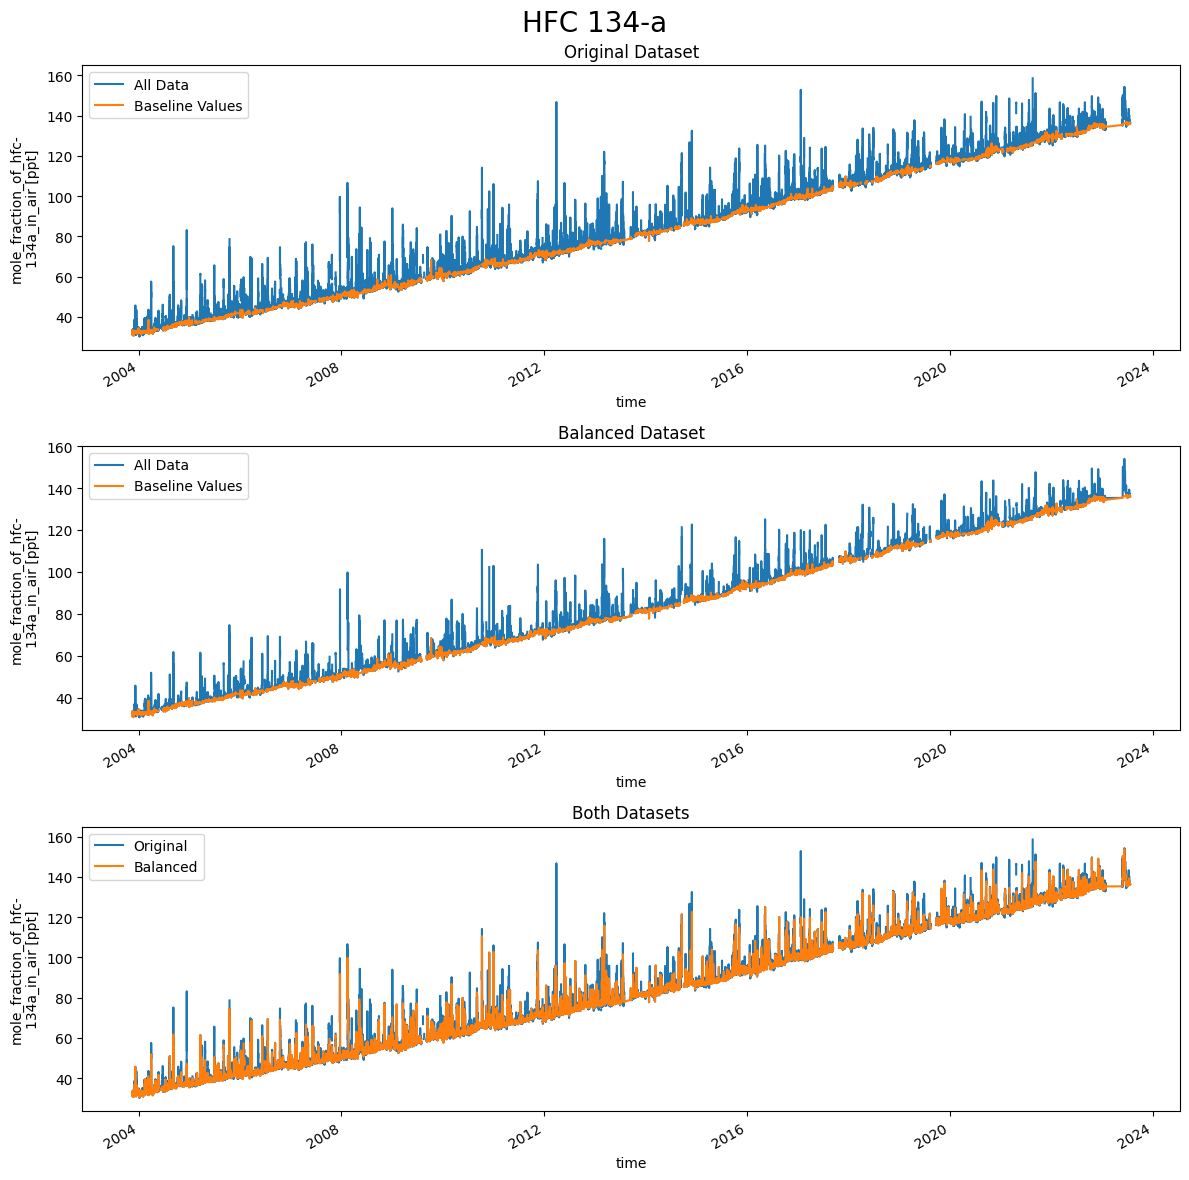

In [23]:
# comparing original and balanced data - no significant data loss
# can I quantify this further?
fig, axs = plt.subplots(3,1, figsize=(12,12))

ds_uvf.mf.plot(ax=axs[0], label="All Data")
ds_uvf.where(ds_uvf.baseline == 1, drop=True).mf.plot(ax=axs[0], label="Baseline Values")
axs[0].set_title("Original Dataset")
axs[0].legend()

ds_uvf_balanced.mf.plot(ax=axs[1], label="All Data")
ds_uvf.where(ds_uvf_balanced.baseline == 1, drop=True).mf.plot(ax=axs[1], label="Baseline Values")
axs[1].set_title("Balanced Dataset")
axs[1].legend()

ds_uvf.mf.plot(ax=axs[2], label="Original")
ds_uvf_balanced.mf.plot(ax=axs[2], label="Balanced")
axs[2].set_title("Both Datasets")
axs[2].legend()

fig.suptitle("HFC 134-a", fontsize=20)
fig.set_tight_layout(True)

In [24]:
# Convert to a pandas dataframe - UNBALANCED
df_uvf = pd.DataFrame({"flag": ds_uvf.baseline.values},
                      index=ds_uvf.time.values)


# IF MULTIPLE POINT SYSTEM
for point in ds_uvf.points.values:
    df_uvf[f"u_{point}"] = ds_uvf.uwnd.sel(points=point).values
    df_uvf[f"v_{point}"] = ds_uvf.vwnd.sel(points=point).values


# IF SINGULAR POINT SYSTEM
#df_uvf["u"] = ds_uvf.uwnd.values
#df_uvf["v"] = ds_uvf.vwnd.values   

# surface pressure
df_uvf["pres"] = ds_uvf.pres.values

# Include time of day as another feature (probably doesn't help, but you never know)
df_uvf["time_of_day"] = df_uvf.index.hour

In [25]:
# Convert to a pandas dataframe - BALANCED
df_uvf_balanced = pd.DataFrame({"flag": ds_uvf_balanced.baseline.values},
                      index=ds_uvf_balanced.time.values)


# IF MULTIPLE POINT SYSTEM
for point in ds_uvf_balanced.points.values:
    df_uvf_balanced[f"u_{point}"] = ds_uvf_balanced.uwnd.sel(points=point).values
    df_uvf_balanced[f"v_{point}"] = ds_uvf_balanced.vwnd.sel(points=point).values

# IF SINGULAR POINT SYSTEM
#df_uvf_balanced["u"] = ds_uvf_balanced.uwnd.values
#df_uvf_balanced["v"] = ds_uvf_balanced.vwnd.values 

# surface pressure
df_uvf_balanced["pres"] = ds_uvf_balanced.pres.values  

# Time of day
# Include for RF, ignore for GBT
df_uvf_balanced["time_of_day"] = df_uvf_balanced.index.hour

In [26]:
# Save to a CSV file - COMMENT OUT BALANCED/NON BALANCED
# NON BALANCED
#df_uvf.index.name = 'time'
#df_uvf.to_csv('/Users/kirst/Downloads/uvf.csv', index=True)

# BALANCED
df_uvf_balanced.index.name = 'time'
df_uvf_balanced.to_csv('/Users/kirst/Downloads/uvf.csv', index=True)

In [27]:
df_uvf_balanced.columns

Index(['flag', 'u_0', 'v_0', 'u_1', 'v_1', 'u_2', 'v_2', 'u_3', 'v_3', 'u_4',
       'v_4', 'u_5', 'v_5', 'u_6', 'v_6', 'u_7', 'v_7', 'u_8', 'v_8', 'pres',
       'time_of_day'],
      dtype='object')

#### Evaluating & Plotting Model

In [81]:
# Load model
rf_model = load('/Users/kirst/Downloads/rf_model1.joblib')

# Predict baseline values
df_predict = df_uvf_balanced.copy()
df_predict.drop(columns=["flag"], inplace=True)
df_uvf_balanced["predicted_flag"] = rf_model.predict(df_predict.reset_index(drop=True))

df_plot = df_uvf_balanced.copy()
df_plot["mf"] = ds_uvf_balanced.mf.values

In [82]:
actual_values = df_plot["mf"].where((df_plot["flag"] == 1)).dropna()
predicted_values = df_plot["mf"].where(df_plot["predicted_flag"] == 1).dropna()


actual_mean = actual_values.mean()
predicted_mean = predicted_values.mean()

actual_std = actual_values.std()
predicted_std = predicted_values.std()

print(f'Actual Mean: {actual_mean:.3f}, Predicted Mean: {predicted_mean:.3f}')
print(f'Actual Std Dev: {actual_std:.3f}, Predicted Std Dev: {predicted_std:.3f}')

Actual Mean: 1.197, Predicted Mean: 1.204
Actual Std Dev: 0.558, Predicted Std Dev: 0.559


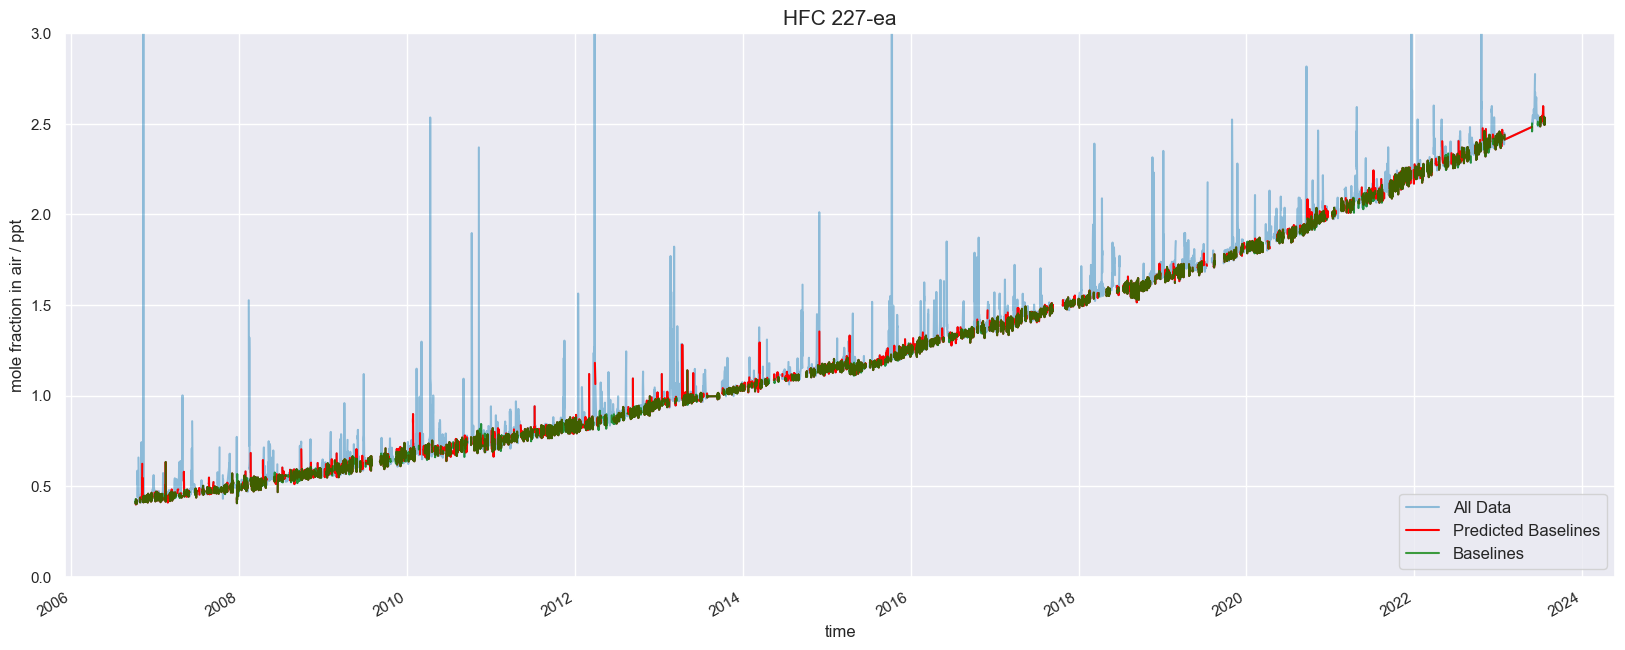

In [85]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

df_plot["mf"].plot(ax=ax, label="All Data", alpha=0.4)
df_plot["mf"].where(df_plot["predicted_flag"] == 1).plot(ax=ax, label="Predicted Baselines", color='red')
df_plot["mf"].where(df_plot["flag"] == 1).plot(ax=ax, label="Baselines", color='green', alpha=0.75)

# limits to view certain dates if wanted
#plt.xlim(datetime.datetime(2016, 1, 1), datetime.datetime(2022, 12, 31))
plt.ylim(0, 3)

plt.ylabel("mole fraction in air / ppt")
plt.title("HFC 227-ea", fontsize=15)
plt.legend(loc="lower right", fontsize=12)